In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2e-20

nband = 120

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 980

data w_diffuse
     &     /1.6 , 1.75 , 1.55 , 1.66,
     &     1.66 , 1.66 , 1.66/

data wgt
     &     /0.35 , 0.6 , 0.5 , 0.55,
     &     0.7 , 0.9 , 1.0/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

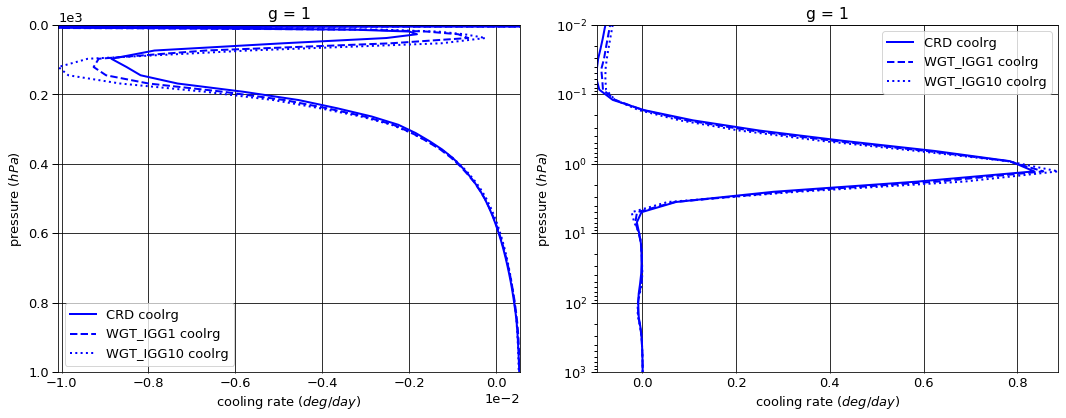

# Figure: cooling rate g-group 2

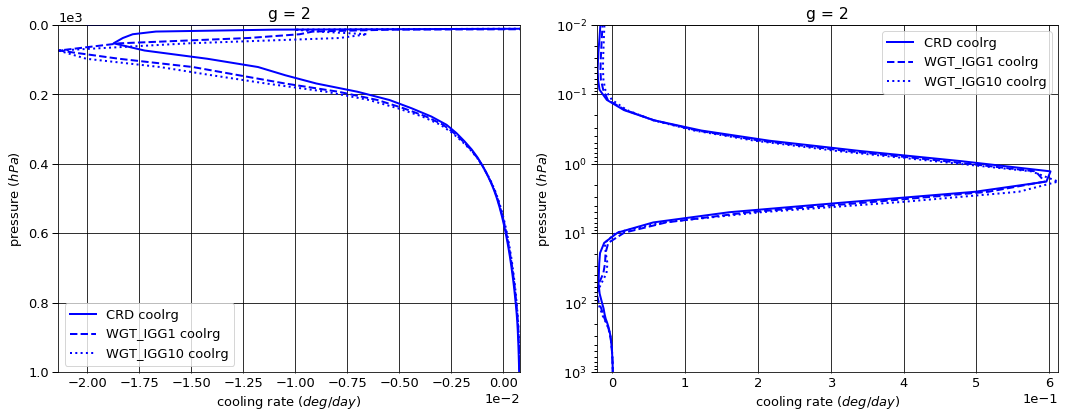

# Figure: cooling rate g-group 3

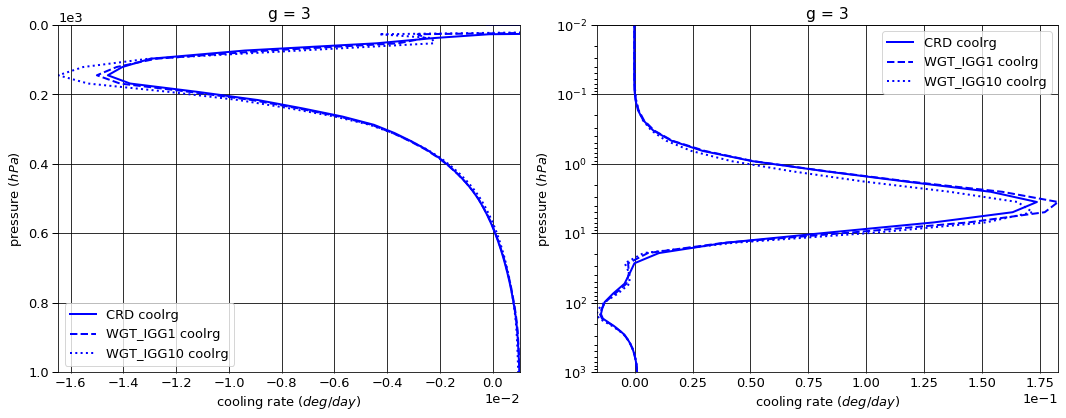

# Figure: cooling rate g-group 4

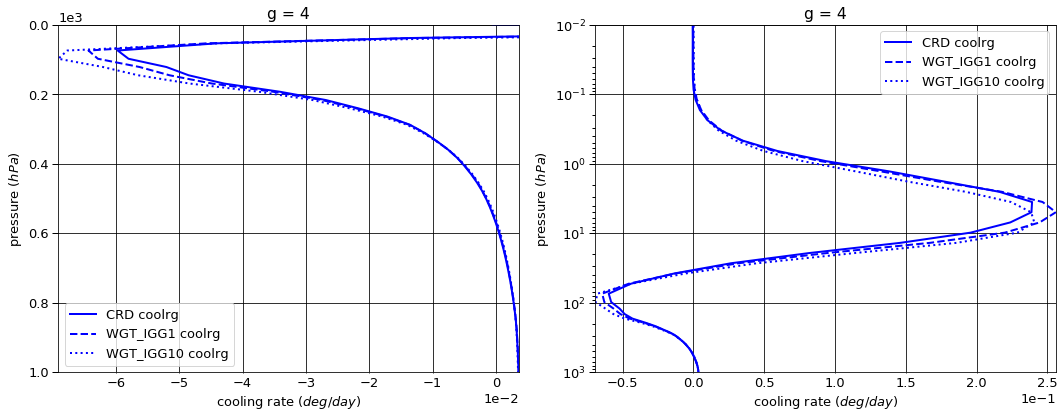

# Figure: cooling rate g-group 5

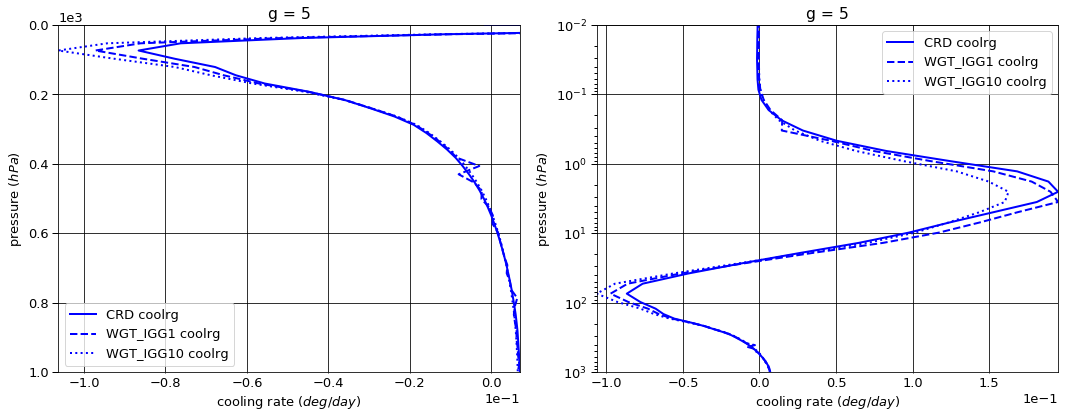

# Figure: cooling rate g-group 6

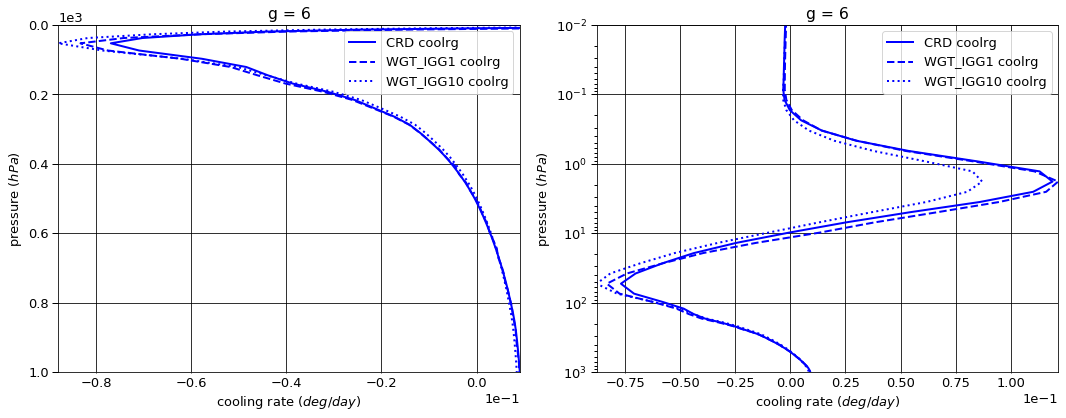

# Figure: cooling rate g-group 7

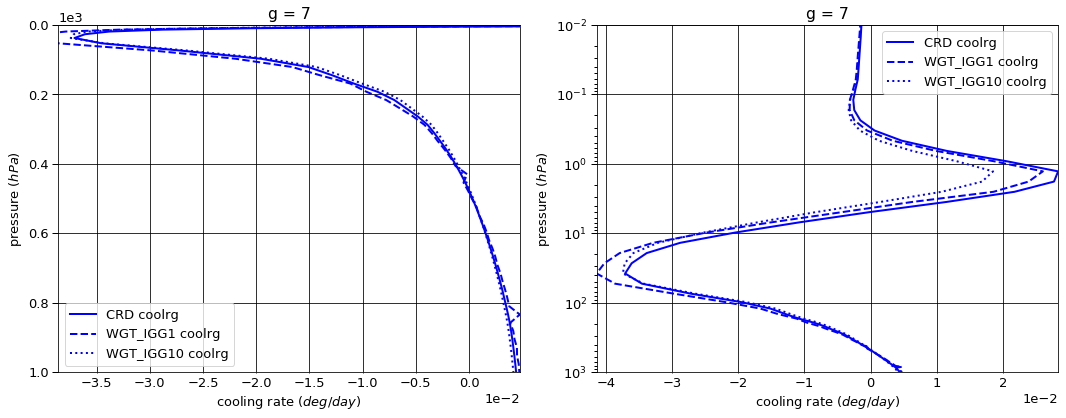

# Figure: cooling rate g-group total

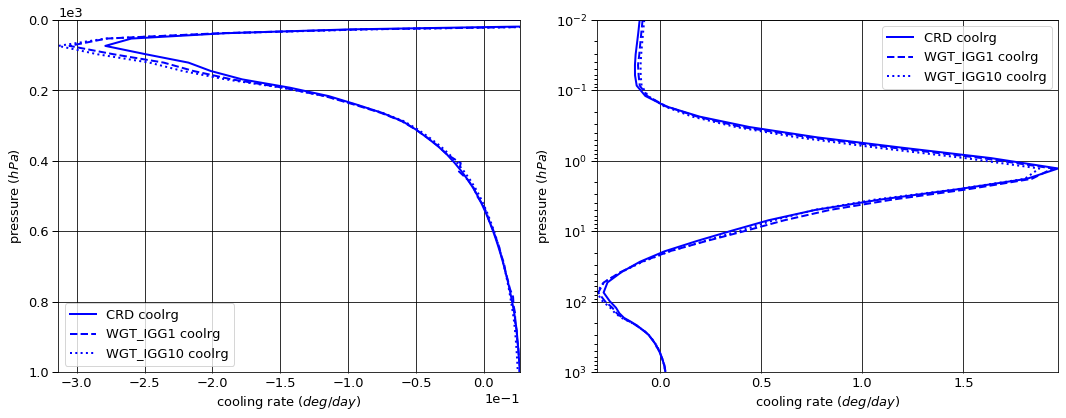

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.163638  0.000000  -0.163638
  1013.0   76     -0.294086  0.109145  -0.184942
2 0.0      1      -0.242181  0.000000  -0.242181
  1013.0   76     -0.507945  0.168281  -0.339665
3 0.0      1      -0.176573  0.000000  -0.176573
  1013.0   76     -0.509275  0.203467  -0.305808
4 0.0      1      -0.581051  0.000000  -0.581051
  1013.0   76     -2.057333  0.727842  -1.329491
5 0.0      1      -1.739547  0.000000  -1.739547
  1013.0   76     -4.401203  1.293464  -3.107739
6 0.0      1      -4.867700  0.000000  -4.867700
  1013.0   76     -7.341066  1.331663  -6.009403
7 0.0      1     -15.310862  0.000000 -15.310862
  1013.0   76    -16.243329  0.533898 -15.709431


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.166386  0.000000  -0.166386
  1013.0   76     -0.294086  0.110485  -0.183602
2 0.0      1      -0.240383  0.000000  -0.240383
  1013.0   76     -0.507945  0.166312  -0.341634
3 0.0      1      -0.180422  0.000000  -0.180422
  1013.0   76     -0.509275  0.204598  -0.304677
4 0.0      1      -0.570727  0.000000  -0.570727
  1013.0   76     -2.057333  0.726407  -1.330926
5 0.0      1      -1.697813  0.000000  -1.697813
  1013.0   76     -4.401203  1.267960  -3.133243
6 0.0      1      -4.818364  0.000000  -4.818364
  1013.0   76     -7.341066  1.327916  -6.013149
7 0.0      1     -15.224962  0.000000 -15.224962
  1013.0   76    -16.243329  0.571357 -15.671972


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.169363  0.000000  -0.169363
  1013.0   76     -0.294086  0.106544  -0.187543
2 0.0      1      -0.245284  0.000000  -0.245284
  1013.0   76     -0.507945  0.164464  -0.343481
3 0.0      1      -0.177859  0.000000  -0.177859
  1013.0   76     -0.509275  0.195438  -0.313837
4 0.0      1      -0.550954  0.000000  -0.550954
  1013.0   76     -2.057333  0.709550  -1.347783
5 0.0      1      -1.578265  0.000000  -1.578265
  1013.0   76     -4.401203  1.250322  -3.150880
6 0.0      1      -4.833072  0.000000  -4.833072
  1013.0   76     -7.341066  1.268779  -6.072287
7 0.0      1     -15.347166  0.000000 -15.347166
  1013.0   76    -16.243329  0.497926 -15.745403


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -2.747670e-03  0.000000 -0.002748
  1013.0   76     0.000000e+00  0.001340  0.001340
2 0.0      1      1.797720e-03  0.000000  0.001798
  1013.0   76     0.000000e+00 -0.001969 -0.001969
3 0.0      1     -3.848390e-03  0.000000 -0.003848
  1013.0   76     0.000000e+00  0.001132  0.001132
4 0.0      1      1.032360e-02  0.000000  0.010324
  1013.0   76     0.000000e+00 -0.001435 -0.001435
5 0.0      1      4.173450e-02  0.000000  0.041734
  1013.0   76    -8.881784e-16 -0.025504 -0.025504
6 0.0      1      4.933620e-02  0.000000  0.049336
  1013.0   76     0.000000e+00 -0.003746 -0.003746
7 0.0      1      8.590000e-02  0.000000  0.085900
  1013.0   76     0.000000e+00  0.037459  0.037459


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -5.725460e-03  0.000000 -0.005725
  1013.0   76     0.000000e+00 -0.002601 -0.002601
2 0.0      1     -3.102370e-03  0.000000 -0.003102
  1013.0   76     0.000000e+00 -0.003816 -0.003816
3 0.0      1     -1.285480e-03  0.000000 -0.001285
  1013.0   76     0.000000e+00 -0.008029 -0.008029
4 0.0      1      3.009703e-02  0.000000  0.030097
  1013.0   76     0.000000e+00 -0.018292 -0.018292
5 0.0      1      1.612829e-01  0.000000  0.161283
  1013.0   76    -8.881784e-16 -0.043141 -0.043142
6 0.0      1      3.462810e-02  0.000000  0.034628
  1013.0   76     0.000000e+00 -0.062884 -0.062884
7 0.0      1     -3.630400e-02  0.000000 -0.036304
  1013.0   76     0.000000e+00 -0.035972 -0.035972

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.037338
  1001.112500 75     0.000534
2 0.000312    1     -0.006196
  1001.112500 75     0.000757
3 0.000312    1     -0.000069
  1001.112500 75     0.001011
4 0.000312    1     -0.000198
  1001.112500 75     0.003586
5 0.000312    1     -0.000531
  1001.112500 75     0.007038
6 0.000312    1     -0.000823
  1001.112500 75     0.009101
7 0.000312    1     -0.000463
  1001.112500 75     0.004422


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.026588
  1001.112500 75     0.000547
2 0.000312    1     -0.005140
  1001.112500 75     0.000786
3 0.000312    1     -0.000050
  1001.112500 75     0.001028
4 0.000312    1     -0.000063
  1001.112500 75     0.003604
5 0.000312    1     -0.000271
  1001.112500 75     0.006502
6 0.000312    1     -0.000698
  1001.112500 75     0.008936
7 0.000312    1     -0.000521
  1001.112500 75     0.004723


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.024056
  1001.112500 75     0.000523
2 0.000312    1     -0.004195
  1001.112500 75     0.000788
3 0.000312    1     -0.000027
  1001.112500 75     0.000965
4 0.000312    1     -0.000009
  1001.112500 75     0.003507
5 0.000312    1     -0.000206
  1001.112500 75     0.006535
6 0.000312    1     -0.000763
  1001.112500 75     0.008456
7 0.000312    1     -0.000487
  1001.112500 75     0.004163


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.010749
  1001.112500 75     0.000013
2 0.000312    1      0.001055
  1001.112500 75     0.000029
3 0.000312    1      0.000019
  1001.112500 75     0.000017
4 0.000312    1      0.000135
  1001.112500 75     0.000018
5 0.000312    1      0.000261
  1001.112500 75    -0.000536
6 0.000312    1      0.000125
  1001.112500 75    -0.000164
7 0.000312    1     -0.000058
  1001.112500 75     0.000300


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.013282
  1001.112500 75    -0.000011
2 0.000312    1      0.002000
  1001.112500 75     0.000031
3 0.000312    1      0.000043
  1001.112500 75    -0.000046
4 0.000312    1      0.000189
  1001.112500 75    -0.000079
5 0.000312    1      0.000325
  1001.112500 75    -0.000502
6 0.000312    1      0.000061
  1001.112500 75    -0.000645
7 0.000312    1     -0.000025
  1001.112500 75    -0.000259

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.081552,0.000000,-23.081552
1013.0,76,-31.354237,4.367759,-26.986478



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.899056,0.000000,-22.899056
1013.0,76,-31.354237,4.375035,-26.979202



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.901962,0.000000,-22.901962
1013.0,76,-31.354237,4.193023,-27.161214



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.824960e-01,0.000000,0.182496
1013.0,76,-3.552714e-15,0.007276,0.007276



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.795907e-01,0.000000,0.179591
1013.0,76,-3.552714e-15,-0.174736,-0.174736


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.045618
1001.112500,75,0.026448



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.033332
1001.112500,75,0.026125



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.029743
1001.112500,75,0.024937



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.012286
1001.112500,75,-0.000323



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.015875
1001.112500,75,-0.001512


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.009375,0.009365
2,0.016083,0.016227
3,0.016292,0.016195
4,0.065542,0.065542
5,0.139458,0.140541
6,0.230792,0.235277
7,0.522458,0.516853


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.739131e-18
2,6.037014e-19
3,9.917477e-19
4,2.699552e-19
5,7.348223e-20
6,2.000197e-20
7,1.127665e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.739131e-18,NaN,0.009375,0.009365,0.009375,0.009365,1.0
2,6.037014e-19,0.161455,0.016083,0.016227,0.025458,0.025592,1.0
3,9.917477e-19,1.642779,0.016292,0.016195,0.041750,0.041787,50.0
4,2.699552e-19,0.272202,0.065542,0.065542,0.107292,0.107329,50.0
5,7.348223e-20,0.272202,0.139458,0.140541,0.246750,0.247870,50.0
6,2.000197e-20,0.272202,0.230792,0.235277,0.477542,0.483147,50.0
7,1.127665e-22,0.005638,0.522458,0.516853,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.036627e-17  7.282641e-18   1.423421  1.198076e-05
      2 0.000312     1.270613e-18  8.529447e-19   1.489678  1.581136e-06
      3 0.000312     1.971722e-20  1.888748e-20   1.043931  2.765598e-08
      4 0.000312     1.968951e-20  1.483392e-20   1.327330  2.508005e-08
      5 0.000312     1.800359e-20  8.286443e-21   2.172657  2.161840e-08
      6 0.000312     8.726391e-21  3.402308e-21   2.564845  1.174016e-08
      7 0.000312     1.362924e-21  5.101312e-23  26.717119  1.952767e-09
2     1 0.000750     1.036092e-17  7.284855e-18   1.422254  5.412136e-06
      2 0.000750     1.272611e-18  8.546595e-19   1.489027  7.155124e-07
      3 0.000750     1.986699e-20  1.902940e-20   1.044015  1.258824e-08
      4 0.000750     1.976751e-20  1.488959e-20   1.327606  1.137413e-08
      5 0.000750     1.806741e-20  8.305136e-21   2.175450  9.798850e-09
      6 0.000750     8.756275e-21  3.410274e-21   2.567616  5.321647e-09
      7 0.000750     1.366651e-21  5.117220e-23  26.706909  8.845929e-10
3     1 0.001052     1.034994e-17  7.289576e-18   1.419828  9.230823e-06
      2 0.001052     1.276787e-18  8.581960e-19   1.487757  1.224804e-06
      3 0.001052     2.010882e-20  1.925663e-20   1.044254  2.173115e-08
      4 0.001052     1.991908e-20  1.499414e-20   1.328458  1.954524e-08
      5 0.001052     1.820136e-20  8.342425e-21   2.181783  1.683013e-08
      6 0.001052     8.819745e-21  3.426596e-21   2.573908  9.142194e-09
      7 0.001052     1.374591e-21  5.145060e-23  26.716705  1.517647e-09
4     1 0.001476     1.033822e-17  7.294454e-18   1.417271  1.526704e-05
      2 0.001476     1.281217e-18  8.619559e-19   1.486407  2.033554e-06
      3 0.001476     2.037910e-20  1.951103e-20   1.044491  3.642470e-08
      4 0.001476     2.008299e-20  1.510755e-20   1.329335  3.258771e-08
      5 0.001476     1.834438e-20  8.382362e-21   2.188450  2.804351e-08
      6 0.001476     8.887549e-21  3.444020e-21   2.580574  1.523677e-08
      7 0.001476     1.383104e-21  5.175652e-23  26.723279  2.525896e-09
5     1 0.002070     1.032632e-17  7.299203e-18   1.414719  2.467712e-05
      2 0.002070     1.285666e-18  8.657456e-19   1.485039  3.299746e-06
      3 0.002070     2.067197e-20  1.978745e-20   1.044701  5.972356e-08
      4 0.002070     2.025208e-20  1.522528e-20   1.330161  5.311140e-08
      5 0.002070     1.848900e-20  8.423060e-21   2.195045  4.566930e-08
      6 0.002070     8.956086e-21  3.461672e-21   2.587214  2.481869e-08
      7 0.002070     1.391743e-21  5.208051e-23  26.722913  4.108801e-09
6     1 0.002904     1.031423e-17  7.303806e-18   1.412172  3.922304e-05
      2 0.002904     1.290136e-18  8.695724e-19   1.483645  5.265329e-06
      3 0.002904     2.099549e-20  2.009382e-20   1.044873  9.641976e-08
      4 0.002904     2.042781e-20  1.534876e-20   1.330910  8.514477e-08
      5 0.002904     1.863531e-20  8.464752e-21   2.201518  7.313916e-08
      6 0.002904     9.025332e-21  3.479606e-21   2.593780  3.975479e-08
      7 0.002904     1.400505e-21  5.242913e-23  26.712345  6.572822e-09
7     1 0.004074     1.030188e-17  7.308248e-18   1.409624  6.151016e-05
      2 0.004074     1.294637e-18  8.734514e-19   1.482208  8.289886e-06
      3 0.004074     2.136126e-20  2.044152e-20   1.044994  1.538589e-07
      4 0.004074     2.061243e-20  1.548009e-20   1.331544  1.347308e-07
      5 0.004074     1.878363e-20  8.507816e-21   2.207809  1.155770e-07
      6 0.004074     9.095341e-21  3.497920e-21   2.600214  6.283208e-08
      7 0.004074     1.409398e-21  5.281197e-23  26.687104  1.037484e-08
8     1 0.005714     1.028919e-17  7.312506e-18   1.407067  9.541634e-05
      2 0.005714     1.299180e-18  8.774036e-19   1.480709  1.291128e-05
      3 0.005714     2.178545e-20  2.084645e-20   1.045044  2.434530e-07
      4 0.005714     2.080907e-20  1.562228e-20   1.332013  2.110062e-07
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
